# Modèle de mélanges gaussiens pour la génération de données

In [2]:
%matplotlib inline
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
import scipy.stats as sps
from sklearn.datasets import make_blobs
from sklearn.mixture import GaussianMixture as GMM
from sklearn.datasets import load_digits
import seaborn as sns; sns.set()

## 1. Modèle de mélange gaussien

### T1. Montrons que $X$ est un vecteur aléatoire à densité sur $\mathbb{R}^d$ et calculons sa densité de probabilité $f_\theta$

Les événements $\{Z=k\}_{k=1}^K$ formant un système complet, la probabilité que $X$ appartienne à un ensemble mesurable $A \subset \mathbb{R}^d$ est donnée par la formule des probabilités totales :

$$\mathbb{P}(X \in A) = \sum_{k=1}^{K} \mathbb{P}(X \in A \mid Z = k) \cdot \mathbb{P}(Z = k)$$

Puisque $X \mid (Z=k) \sim \mathcal{N}(\mu_k, \Sigma_k)$, sa densité est $f_{\mu_k, \Sigma_k}$. En substituant cette densité dans l'expression précédente, on obtient :

$$\mathbb{P}(X \in A) = \sum_{k=1}^{K} \pi_k \int_A f_{\mu_k, \Sigma_k}(x) dx = \int_A \sum_{k=1}^{K} \pi_k f_{\mu_k, \Sigma_k}(x) dx$$

Ainsi, $X$ est un vecteur aléatoire à densité sur $\mathbb{R}^d$, et sa densité de probabilité $f_\theta(x)$ est :

$$f_\theta(x) = \sum_{k=1}^{K} \pi_k \cdot \frac{1}{(2\pi)^{d/2} \sqrt{\det(\Sigma_k)}} \exp\left( -\frac{1}{2}(x - \mu_k)^T \Sigma_k^{-1} (x - \mu_k) \right)$$

Cette fonction $f_\theta(x)$ est une densité valide car elle est une combinaison convexe de densités gaussiennes.

### S1. Implémentation d'une fonction de génération d'échantillons i.i.d. à partir d'un mélange gaussien et visualisation pour $d=1$

Pi:  [0.18451732 0.29117779 0.21404211 0.18250647 0.12775631]
Mu:
 [[-0.84272405]
 [ 1.96992445]
 [ 1.26611853]
 [-0.50587654]
 [ 2.54520078]]
Sigma:
 [[[1.85863361]]

 [[0.23496851]]

 [[0.26554567]]

 [[0.13841496]]

 [[1.68197771]]]


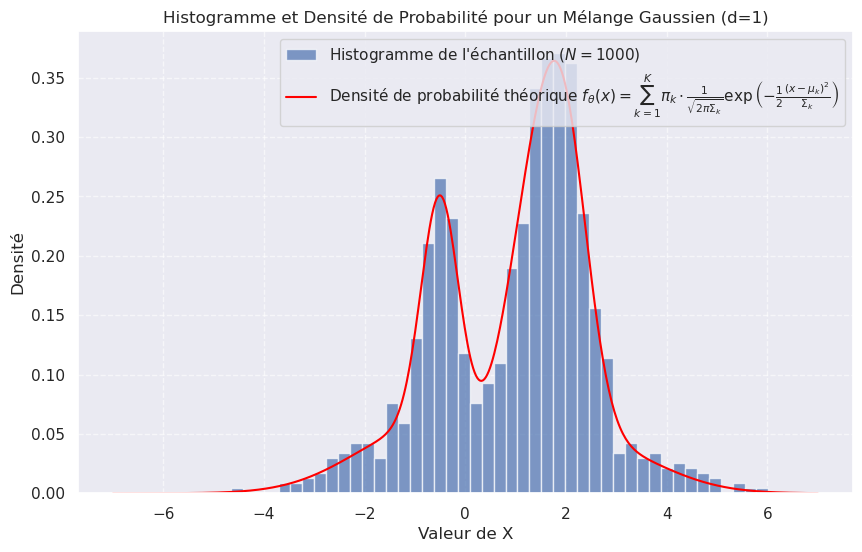

In [4]:
def simulation_X(K: int, theta: tuple[np.ndarray, np.ndarray, np.ndarray], n: int) -> tuple[np.ndarray, np.ndarray]:
    """Génère n réalisations i.i.d. d'un mélange gaussien."""
    pi, mu, sigma = theta
    simul_Z = npr.choice(range(K), p=pi, size=n)
    X_samples = np.array([
        sps.multivariate_normal(mu[z], sigma[z]).rvs()
        for z in simul_Z
    ])
    return X_samples, simul_Z

def pdf_X(X: np.ndarray | np.ndarray[np.ndarray], theta: tuple[np.ndarray, np.ndarray, np.ndarray]) -> float | np.ndarray:
    """Calcule la densité de probabilité f_theta(x) pour un mélange gaussien."""
    pi, mu, sigma = theta
    component_pdfs = np.array([
        sps.multivariate_normal(mu[k], sigma[k]).pdf(X)
        for k in range(len(pi))
    ])
    return np.dot(pi, component_pdfs)

""" Paramètres du modèle et génération """
d = 1
K = 5
np.random.seed(0)

# Génération des poids des composantes (Pi).
# np.random.dirichlet(np.ones(K)) génère un vecteur de probabilités Pi
# où chaque élément est tiré d'une distribution de Dirichlet avec des paramètres alpha_i = 1.
# Cela assure que la somme des poids est 1, et qu'ils sont tous positifs,
# ce qui est essentiel pour une distribution de probabilité.
Pi = npr.dirichlet(np.ones(K))
print("Pi: ", Pi)

Mu = npr.randn(K, d)
print("Mu:\n", Mu)

# Génération des matrices de covariance (Sigma).
# Pour une dimension d=1, la matrice de covariance est un scalaire (la variance).
# np.diag est utilisé ici pour créer une matrice diagonale à partir de scalaires générés.
# Pour d > 1, cela produirait des matrices de covariance diagonales, simplifiant le modèle
# et assurant la positivité des variances.
Sigma = np.array([np.diag(npr.uniform(0.1, 2, size=d)) for _ in range(K)])
print("Sigma:\n", Sigma)

theta = (Pi, Mu, Sigma)

""" Simulation """
N = 1000
X_samples, Z_samples = simulation_X(K, theta, N)

""" Tracé (effectué uniquement dans le cas d=1) """
if d == 1:
    X_min, X_max = -7, 7 
    X_samples = X_samples.flatten()   
    num_bins = int(N ** (1./3.)) * 5

    plt.figure(figsize=(10, 6))

    plt.hist(X_samples, density=True, label=f"Histogramme de l'échantillon ($N={N}$)", bins=num_bins, alpha=0.7)
    
    x_plot = np.linspace(X_min, X_max, 500)
    pdf_values = pdf_X(x_plot, theta)

    plt.plot(x_plot, pdf_values, label=r"Densité de probabilité théorique $f_\theta(x) = \sum_{k=1}^{K} \pi_k \cdot \frac{1}{\sqrt{2\pi \Sigma_k}} \exp\left( -\frac{1}{2}\frac{(x - \mu_k)^2}{\Sigma_k} \right)$", color='red')
    plt.title(f"Histogramme et Densité de Probabilité pour un Mélange Gaussien (d={d})")
    plt.xlabel("Valeur de X")
    plt.ylabel("Densité")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

#### Observations

La densité théorique obtenue, s'adapte plotôt bien à l'histogramme de l'échantillon généré (cas d=1).

## 2. Algorithme d’estimation de paramètres de mélange gaussien

### S2. Implémentation de la fonction de vraisemblance $l_\theta((x_i)_{1 \le i \le n})$

In [5]:
def likelihood(K: int, theta: tuple[np.ndarray, np.ndarray, np.ndarray], X: np.ndarray[np.ndarray]) -> float:
    f_theta = pdf_X(X, theta)

    # Utilise une valeur minimale pour éviter log(0), ce qui résulterait en -inf
    # et rendrait le calcul de la log-vraisemblance instable pour des densités très faibles.
    min_val = 1e-300 
    
    return np.log(np.maximum(f_theta, min_val)).sum()

#### Note : Dans la suite, nous travaillerons dans le cas $d=1$, du moins pour la partie théorique (conformément à l'énoncé).

### T2. Calcul de la densité conjointe $p_\theta$ du couple $(Z,X)$

Soit $g$ une fonction continue et bornée. L'espérance de $g(Z,X)$ peut s'écrire par la formule des probabilités totales :
$$
\mathbb{E}[g(Z, X)] = \sum_{k=1}^{K} \mathbb{E}[g(Z, X) \mid Z = k] \cdot \mathbb{P}[Z = k]
$$
Puisque $X \mid (Z=k) \sim \mathcal{N}(\mu_k, \Sigma_k)$, sa densité est $f_{\mu_k, \Sigma_k}$. On a alors :
$$
\mathbb{E}[g(Z, X) \mid Z = k] = \int_{\mathbb{R}^d} g(k, x) f_{\mu_k, \Sigma_k}(x) \, dx
$$
En substituant cette expression, on obtient :
$$
\mathbb{E}[g(Z, X)] = \sum_{k=1}^{K} \pi_k \int_{\mathbb{R}^d} g(k, x) f_{\mu_k, \Sigma_k}(x) \, dx
$$
Ceci peut être reformulé comme une intégrale par rapport à la mesure produit sur $\{1, \ldots, K\} \times \mathbb{R}^d$:
$$
\mathbb{E}[g(Z, X)] = \int_{\{1,\ldots,K\} \times \mathbb{R}^d} g(k, x) \pi_k f_{\mu_k, \Sigma_k}(x) \, \delta(dk) \, dx
$$
La loi jointe du couple $(Z,X)$ admet donc une densité $p_\theta(k,x)$ par rapport à la mesure produit $\delta_{\{1,\ldots,K\}} \times \lambda$ (où $\delta_{\{1,\ldots,K\}}$ est la mesure de comptage sur $\{1,\ldots,K\}$ et $\lambda$ est la mesure de Lebesgue sur $\mathbb{R}^d$). Cette densité est donnée par :
$$
p_\theta(k, x) = \pi_k f_{\mu_k, \Sigma_k}(x) \mathbb{1}_{\{1,\ldots,K\}}(k)
$$
où $f_{\mu_k, \Sigma_k}(x) = \frac{1}{(2\pi)^{d/2} \sqrt{\det(\Sigma_k)}} \exp\left( -\frac{1}{2}(x - \mu_k)^T \Sigma_k^{-1} (x - \mu_k) \right) = \frac{1}{\sqrt{2 \pi \Sigma_k}} \exp\left( -\frac{1}{2} \frac{(x - \mu_k)^2}{\Sigma_k} \right)$ (dans le cas $d=1$) pour $x \in \mathbb{R}^d$.

### T3. Calcul des probabilités conditionnelles $\mathbb{P}_\theta(Z=k|X=x)$

Nous rappelons les densités pertinentes :
- La densité conjointe de $(Z,X)$ est donnée par :
  $$ p_\theta(k, x) = \pi_k f_{\mu_k, \Sigma_k}(x) \mathbb{1}_{\{1,\ldots,K\}}(k) $$
- La densité marginale de $X$ est donnée par :
  $$ f_\theta(x) = \sum_{l=1}^{K} \pi_l f_{\mu_l, \Sigma_l}(x) $$

Pour $k \in \{1,\ldots,K\}$, la probabilité conditionnelle $\mathbb{P}_\theta(Z=k|X=x)$ s'écrit donc comme le rapport de la densité conjointe à la densité marginale :
$$
\mathbb{P}_\theta(Z = k \mid X = x) = \frac{p_\theta(k, x)}{f_\theta(x)} = \frac{\pi_k f_{\mu_k, \Sigma_k}(x)}{\sum_{l=1}^{K} \pi_l f_{\mu_l, \Sigma_l}(x)}
$$

### T4. Détermination de l'EMV

En nous plaçant dans le cas unidimensionnel ($d=1$), la log-vraisemblance des données complètes, connaissant les étiquettes $(z_i)_{1 \le i \le n}$, s'exprime comme suit :
$$
\ell(\theta) = \sum_{i=1}^{n} \log p_\theta(z_i, x_i) = \sum_{i=1}^{n} \sum_{k=1}^{K} \mathbb{1}_{z_i=k} \left[ \log \pi_k - \frac{1}{2} \log (2\pi \Sigma_k) - \frac{1}{2} \frac{(x_i - \mu_k)^2}{\Sigma_k} \right]
$$
Nous pouvons décomposer la log-vraisemblance en deux parties :
$$
\ell(\theta) = \ell_1(\pi) + \ell_2(\mu, \Sigma)
$$
où
$$
\ell_1(\pi) = \sum_{k=1}^{K} n_k \log \pi_k
$$
et
$$
\ell_2(\mu, \Sigma) = \sum_{k=1}^{K} \sum_{i=1}^{n} \mathbb{1}_{z_i=k} \left[ -\frac{1}{2} \log (2\pi \Sigma_k) - \frac{1}{2} \frac{(x_i - \mu_k)^2}{\Sigma_k} \right]
$$
Nous notons $n_k = \sum_{i=1}^n \mathbb{1}_{z_i=k}$, le nombre d'échantillons associés à la composante $k$.

1.  **Maximisation de $\ell_1$ :**
    Nous cherchons à maximiser $\ell_1(\pi) = \sum_{k=1}^{K} n_k \log \pi_k$ sous la contrainte $\sum_{k=1}^K \pi_k = 1$ et $\pi_k > 0$ pour tout $k$.
    Considérons la différence $\ell_1(\pi) - \ell_1(\tilde{\pi}) = \sum_{k=1}^K n_k \log \left(\frac{\pi_k}{\tilde{\pi}_k}\right)$ où $\tilde{\pi}_k = n_k/n$ pour tout $k$. En utilisant l'inégalité $\log x \le x-1$, on a :
    $$ \sum_{k=1}^K n_k \log \left(\frac{\pi_k}{\tilde{\pi}_k}\right) \le \sum_{k=1}^K n_k \left(\frac{\pi_k}{n_k/n} - 1\right) = n \sum_{k=1}^K \pi_k - n = n \cdot 1 - n = 0 $$
    Ainsi, $\ell_1(\pi) \le \ell_1(\tilde{\pi})$.
    
    Donc, $\ell_1$ atteint son maximum en $\tilde{\pi} = (\tilde{\pi}_k)_{k=1}^K$ où pour tout $k$:
    $$
    \tilde{\pi}_k = \frac{n_k}{n}
    $$

2.  **Maximisation de $\ell_2$ :**

    a.  **Maximisation de $\ell_2$ par rapport à $\mu_k$ (pour $\mu_j$ fixé pour tout $j \ne k$, et $\Sigma_j$ fixé pour tout $j$) :**
        La dérivation de $\ell_2$ par rapport à $\mu_k$ et son égalisation à zéro donnent :
        $$
        \frac{\partial \ell_2}{\partial \mu_k}(\mu, \Sigma) = \sum_{i=1}^{n} \mathbb{1}_{z_i=k} \frac{x_i - \mu_k}{\Sigma_k} = 0
        $$
        Puisque $\Sigma_k > 0$, nous obtenons :
        $$
        \tilde{\mu}_k = \frac{1}{n_k} \sum_{i=1}^{n} x_i \mathbb{1}_{z_i=k}
        $$
        La dérivée seconde, $\frac{\partial^2 \ell_2}{\partial \mu_k^2}(\mu, \Sigma) = -n_k / \Sigma_k$, étant négative, confirme que pour $\mu_j$ fixés pour tout $j \ne k$, et $\Sigma_j$ fixés pour tout $j$, $\ell_2$ atteint son maximum pour $\mu_k = \tilde{\mu}_k$.
        
    $$$$
    Par conséquent, pour $\Sigma_j$ fixés pour tout $j$, $\ell_2$ atteint son maximum pour $\mu = \tilde{\mu} = (\tilde{\mu}_k)_{k=1}^K$.

    Définissons $\ell_{2,1}(\Sigma) = \ell_2(\tilde{\mu}, \Sigma)$.

    b. **Maximisation de $\ell_{2,1}$ par rapport à $\Sigma_k$ (pour $\Sigma_j$ fixés pour tout $j \ne k$) :**
        La dérivation de $\ell_{2,1}$ par rapport à $\Sigma_k$ et son égalisation à zéro donnent :
        $$
        \frac{\partial \ell_{2,1}}{\partial \Sigma_k}(\Sigma) = \sum_{i=1}^{n} \mathbb{1}_{z_i=k} \left[ -\frac{1}{2\Sigma_k} + \frac{1}{2} \frac{(x_i - \tilde{\mu}_k)^2}{\Sigma_k^2} \right] = 0
        $$
        En multipliant par $2\Sigma_k^2$ on a :
        $$
        \sum_{i=1}^{n} \mathbb{1}_{z_i=k} \left[ -\Sigma_k + (x_i - \tilde{\mu}_k)^2 \right] = 0
        $$
        Le maximiseur potentiel $\tilde{\Sigma}_k$ est ainsi donné par :
        $$
        \tilde{\Sigma}_k = \frac{1}{n_k} \sum_{i=1}^{n} \mathbb{1}_{z_i=k} (x_i - \tilde{\mu}_k)^2
        $$
        Pour confirmer qu'il s'agit d'un maximum global, analysons le signe de la dérivée première :
        $\frac{\partial \ell_{2,1}}{\partial \Sigma_k}(\Sigma) = \frac{1}{2\Sigma_k^2} \sum_{i=1}^{n} \mathbb{1}_{z_i=k} \left[ -\Sigma_k + (x_i - \tilde{\mu}_k)^2 \right]$.
        $$$$
        Soit $C_k = \sum_{i=1}^{n} \mathbb{1}_{z_i=k} (x_i - \tilde{\mu}_k)^2 > 0$. 
        $$$$
        On a $\frac{\partial \ell_{2,1}}{\partial \Sigma_k}(\Sigma) = \frac{1}{2\Sigma_k^2} (C_k - n_k \Sigma_k)$.
        $$$$
        - Pour $\Sigma_k \to 0^+$, la dérivée tend vers $+\infty$ (car $C_k > 0$). Ainsi la dérivée partielle est positive sur $]0, \tilde{\Sigma}_k[$.
        $$$$
        D'où la fonction $\ell_{2,1}$ est croissante sur $]0, \tilde{\Sigma}_k[$.        
        $$$$
        - Pour $\Sigma_k \to +\infty$, la dérivée tend vers $O^{-}$. Ainsi la dérivée partielle est négative sur $]\tilde{\Sigma}_k, +\infty[$.
        $$$$
        D'où la fonction $\ell_{2,1}$ est décroissante sur $]\tilde{\Sigma}_k, +\infty[$.
        $$$$
        Ainsi pour $\Sigma_j$ fixés pour tout $j \ne k$, $\ell_{2,1}$ atteint son maximum pour $\Sigma_k = \tilde{\Sigma}_k$.
        
    $$$$
    Par conséquent, $\ell_{2,1}$ atteint son maximum en $\Sigma = \tilde{\Sigma} = (\tilde{\Sigma}_k)_{k=1}^K$.

Donc $\ell_2$ atteint son maximum en $(\tilde{\mu}, \tilde{\Sigma})$.

Ainsi $\ell$ atteint son maximum en $(\tilde{\pi}, \tilde{\mu}, \tilde{\Sigma})$.

Il vient donc que l'EMV est défini par : Pour tout $k \in \{1,...,K\}$,

$$
\hat{\pi}_k = \tilde{\pi}_k = \frac{n_k}{n}
$$
$$
\hat{\mu}_k = \tilde{\mu}_k = \frac{1}{n_k}\sum_{i=1}^{n} \mathbb{1}_{z_i=k}x_{i}
$$
$$
\hat{\Sigma}_k = \tilde{\Sigma}_k = \frac{1}{n_k}\sum_{i=1}^{n} \mathbb{1}_{z_i=k}(x_{i}-\hat{\mu}_{k})^{2}
$$

### S3. Visualisation du fonctionnement de l'algorithme EM pour l'estimation de mélanges gaussiens

In [7]:
def pdf_Z_X(X: np.ndarray | float, theta: tuple[np.ndarray, np.ndarray, np.ndarray]) -> np.ndarray | float:
    pi, mu, sigma = theta
    f_k_x = np.array([sps.multivariate_normal(mu[k], sigma[k]).pdf(X) for k in range(len(pi))])
    val = pi[:, np.newaxis] * f_k_x / np.maximum(pdf_X(X, theta), 1e-300) # Pour éviter un résultat NaN, qui peut surgir si f_X(x) est très faible
    return val.T


def theta_estim(X: np.ndarray, K: int, n_iter: int = 100) -> tuple[tuple[np.ndarray, np.ndarray, np.ndarray], np.ndarray]:
    n, d = X.shape

    Mu = X[npr.choice(n, K, replace=False)]

    # Calcul de la covariance globale des données (X.T pour que les colonnes soient les variables)
    # Ajout d'une petite valeur diagonale pour assurer la non-singularité et la stabilité.
    global_cov = np.cov(X.T)
    if d == 1:
        global_cov = np.array([[global_cov]])
    Sigma = np.array([global_cov + 1e-6 * np.eye(d) for _ in range(K)]) 

    Pi = np.ones(K) / K

    Mu_hist = []
    
    for _ in range(n_iter):
        # E-step
        theta = (Pi, Mu, Sigma)
        # Z = np.array([np.argmax(pdf_Z_X(x, theta)) + 1 for x in X]) # moins efficace car n'utilise pas la vectorisation
        pdf_z_x = np.stack(pdf_Z_X(X, theta))
        Z = np.argmax(pdf_z_x, axis=1) # on considére Z dans 0,...,K-1 pour des questions d'efficacité, car les vraies valeurs sont juste obtenues par translation
        # print("Z:", Z)

        # M-step
        N = np.bincount(Z, minlength=K)
        # print("N:", N)
        X_filtered = [X[Z == k] for k in range(K)]
        # print("X_filtered: ", X_filtered.shape)
        
        Mu = np.array([np.sum(X_filtered[k], axis=0) / N[k] if N[k] != 0 else X[npr.randint(0, n)] for k in range(K)]) # Si n_k = 0, on prend un elt quelconque dans X
        # print("Mu: ", Mu)
        Mu_hist.append(Mu)
        
        for k in range(K):
            if N[k] != 0:
                diff_centered = X_filtered[k] - Mu[k] # Centrage des points
                Sigma[k] = (diff_centered.T @ diff_centered) / N[k]
            else:
                Sigma[k] = global_cov # Réinitialise si le cluster est vide
        # print("Sigma: ", Sigma)
        
        Pi = N / n
        # print("Pi:", Pi)

    return (Pi, Mu, Sigma), np.array(Mu_hist)





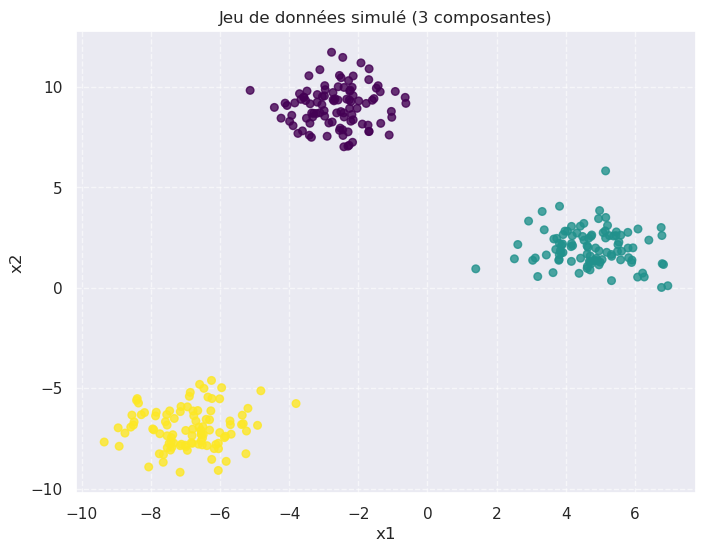

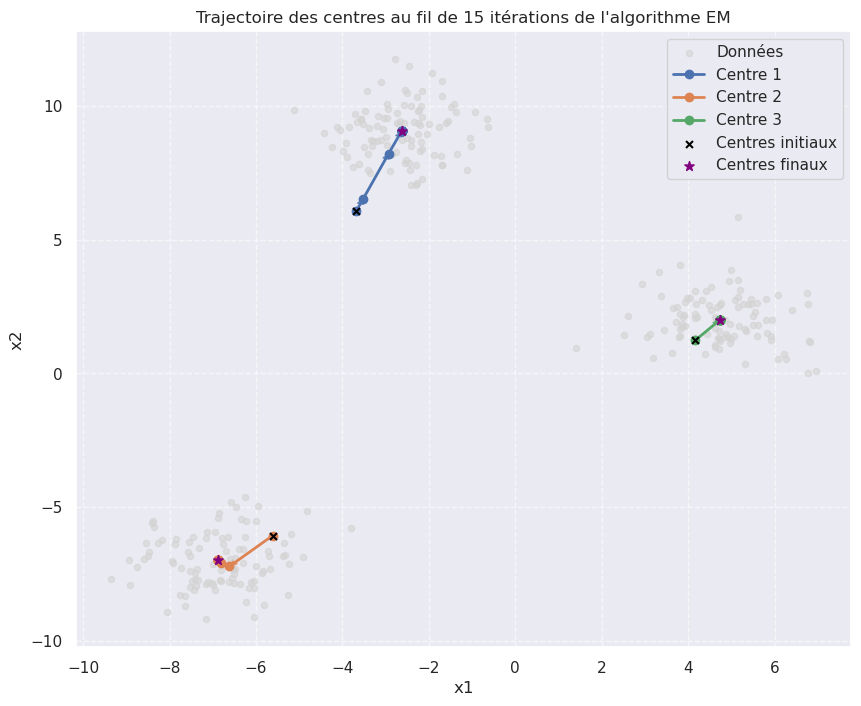

In [8]:

""" Données """
n = 300
K = 3
X, y = make_blobs(n_samples=n, centers=K, n_features=2, cluster_std=1.0, random_state=42)
n_iter = 15

theta, Mu_hist = theta_estim(X, K, n_iter=n_iter)

""" Affichage des points """
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap='viridis', alpha=0.8)
plt.title('Jeu de données simulé (3 composantes)')
plt.xlabel('x1')
plt.ylabel('x2')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

""" Affichage de la trajectoire de chaque centre """
plt.figure(figsize=(10, 8))
m = Mu_hist.shape[1]
plt.scatter(X[:, 0], X[:, 1], c='lightgray', s=20, label='Données', alpha=0.6)
for k in range(m):
    traj = Mu_hist[:, k, :]
    plt.plot(traj[:, 0], traj[:, 1], marker='o', linestyle='-', linewidth=2, 
        label=f'Centre {k+1}', color=f'C{k}', markersize=6)
    # Flèches entre les positions successives
    for t in range(len(traj)-1):
        plt.arrow(traj[t, 0], traj[t, 1],
                  traj[t+1, 0] - traj[t, 0], traj[t+1, 1] - traj[t, 1],
                  head_width=0.15, head_length=0.2, fc=f'C{k}', ec=f'C{k}', alpha=0.7, length_includes_head=True, linewidth=0.8)

initial_centers = Mu_hist[0]
plt.scatter(initial_centers[:, 0], initial_centers[:, 1], marker='x', s=25, 
            color='black', label='Centres initiaux', zorder=5)

final_centers = Mu_hist[-1]
plt.scatter(final_centers[:, 0], final_centers[:, 1], marker='*', s=50, 
            color='purple', label='Centres finaux', zorder=5)

plt.title(f"Trajectoire des centres au fil de {n_iter} itérations de l'algorithme EM")
plt.xlabel("x1")
plt.ylabel("x2")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

#### Observations sur la trajectoire des centres :
- **Convergence :** Les centres semblent converger rapidement vers les centres des regroupements de données.
- **Ralentissement progressif :** Les pas de déplacement des centres diminuent à mesure que l'algorithme progresse, indiquant un ralentissement vers la convergence. Ce phénomène est visible par les flèches qui raccourcissent entre les points successifs des trajectoires.
- **Influence de l'initialisation :** L'initialisation aléatoire des centres influence le chemin de convergence, mais pour des clusters bien séparés, le résultat final est généralement stable.

## 3. Application à de vraies données

### Importation des données

In [9]:
digits = load_digits()
data = digits.data
data.shape

(1797, 64)

### Visualisation des données

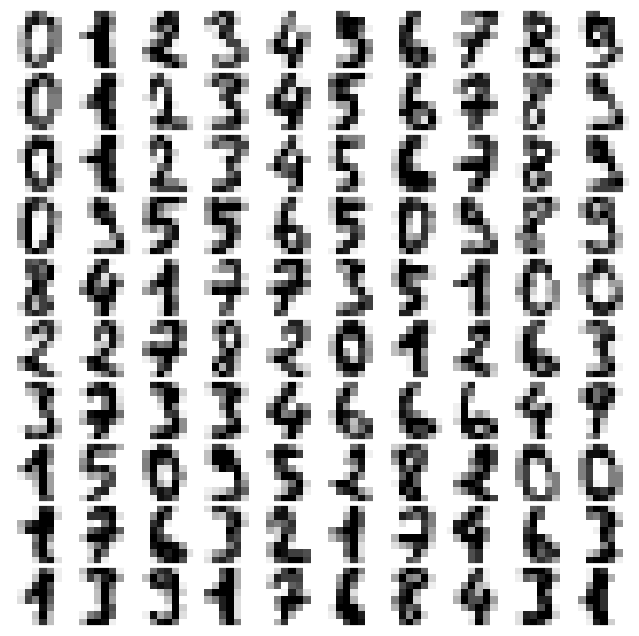

In [10]:
def plot_digits(data):
    fig, ax = plt.subplots(10, 10, figsize=(8, 8),
                           subplot_kw=dict(xticks=[], yticks=[]))
    fig.subplots_adjust(hspace=0.05, wspace=0.05)
    for i, axi in enumerate(ax.flat):
        im = axi.imshow(data[i].reshape(8, 8), cmap='binary')
        im.set_clim(0, 16)
plot_digits(digits.data)

### Création & Entrainement des modèles

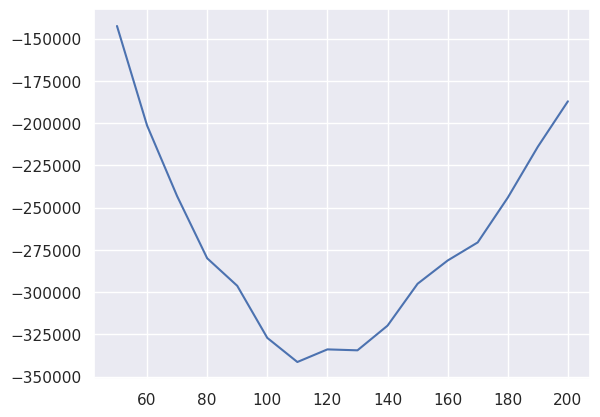

In [12]:
K_components = np.arange(50, 210, 10)
models = [GMM(K, covariance_type='full', random_state=0)
          for K in K_components]
aics = [model.fit(data).aic(data) for model in models]
plt.plot(K_components, aics)

### S4.Nombre d'images dans la base de données

La base de données contient 1797 images. Cela est indiqué par la sortie de la ligne de code digits.data.shape, qui renvoie (1797, 64), signifiant qu'il y a 1797 images, chacune composée de 64 pixels (car les images sont de taille 8x8).

### S5. Rôle de la fonction `plot_digits(data)` ?

La fonction `plot_digits(data)` visualise les images de chiffres manuscrits. Elle prend un tableau de données aplaties (`data`) et affiche les 100 premières images sous forme de grille 10x10. Chaque vecteur image 1D de 64 pixels est redimensionné en une image 2D de 8x8 pixels et affiché en niveaux de gris ("binary" cmap). Les axes et espacements sont ajustés pour une présentation compacte.

### S6. Explication des dernières lignes de code et observations

Les dernières lignes de code du fichier `project_GM.ipynb` entraînent et évaluent des modèles de mélanges gaussiens (`GaussianMixture` ou `GMM`) sur le dataset `digits.data` en faisant varier le nombre de composantes $K$.

* `K_components = np.arange(50, 210, 10)`: Crée un tableau de valeurs pour 
K allant de 50 à 200 avec un pas de 10.

* `models = [GMM(K, covariance_type='full', random_state=0) for K in K_components]`: Initialise une liste de modèles de mélange gaussien (GMM) avec différentes valeurs de K. 

* `aics = [model.fit(data).aic(data) for model in models]`: Ajuste chaque modèle aux données et calcule le critère d'information d'Akaike (AIC) pour chaque modèle ajusté, en vu d'évaluer sa performance.

* `plt.plot(K_components, aics)`: Trace les valeurs de l'AIC en fonction des différentes valeurs de K.

**Observations :**

Le graphique montre que l'AIC diminue initialement de manière significative à mesure que $K$ augmente, indiquant que l'ajout de composantes améliore la capacité du modèle à s'ajuster aux données. Cependant, après une certaine valeur de K (aux environs de 110), la courbe reprend sa croissance ; on se semble se retrouver alors dans une situation d'overfitting.

### S7. Tracé de la log-vraisemblance $\ell_{\theta^*}((x_i)_{1 \le i \le n})$ suivant les valeurs de $K$, où $\theta^*$ est la valeur obtenue via `model.fit(data)`, et observations

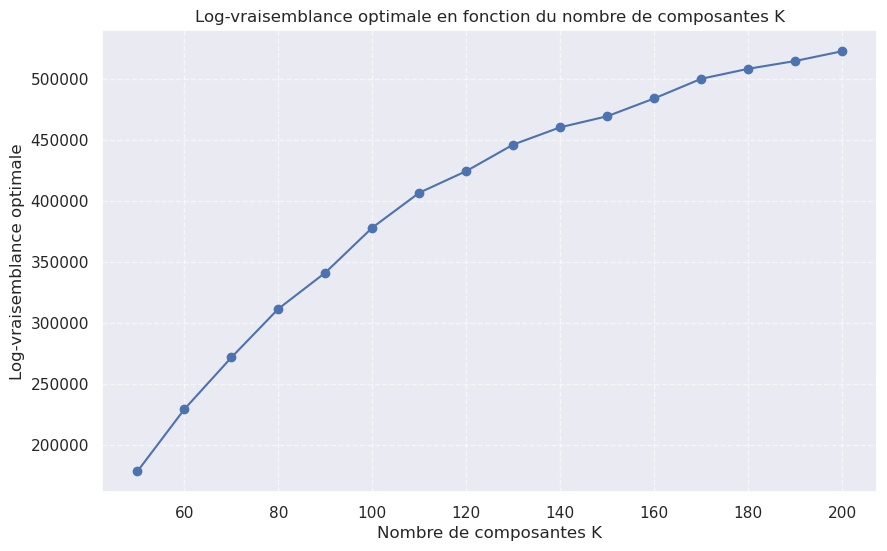

In [13]:
log_likelihood_values = np.array([
    likelihood(K, (model.weights_, model.means_, model.covariances_), data) 
    for K, model in zip(K_components, models)
])

# Tracé des valeurs de la log-vraisemblance
plt.figure(figsize=(10, 6))
plt.plot(K_components, log_likelihood_values, marker='o')
plt.title("Log-vraisemblance optimale en fonction du nombre de composantes K")
plt.xlabel("Nombre de composantes K")
plt.ylabel("Log-vraisemblance optimale")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

#### Observations :

Le graphique montre que la log-vraisemblance augmente avec le nombre de composantes K.
Cela est attendu car un modèle avec plus de composantes a plus de paramètres et peut donc mieux s'adapter aux données d'entraînement, ce qui se traduit par une probabilité plus élevée pour les données observées.
Contrairement à l'AIC (qui pénalise la complexité), la log-vraisemblance seule ne fournit pas d'indication sur le meilleur K en termes de compromis complexité/ajustement, car elle favorisera toujours le modèle le plus complexe.

### S8. Génération d'un échantillon de 100 nouvelles réalisations

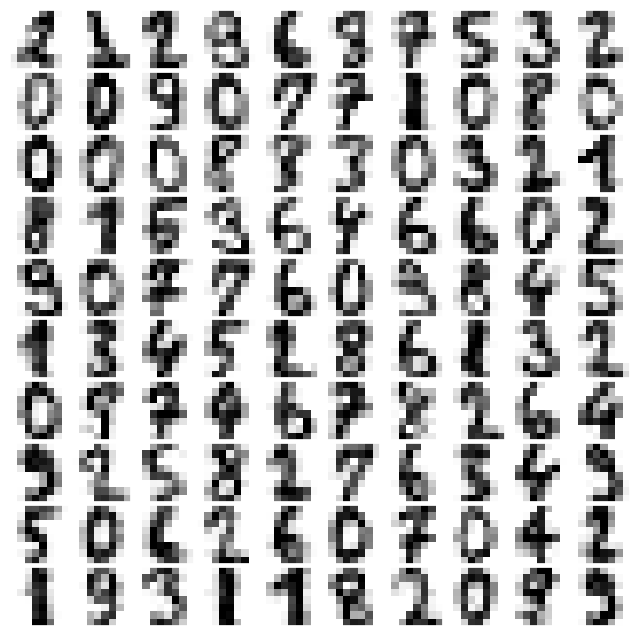

In [17]:
# Ajuster un modèle GMM avec K = 110
optimal_K = 110
n = 100
gmm_model = models[optimal_K // 10 - 5]
theta = (gmm_model.weights_, gmm_model.means_, gmm_model.covariances_)

# Générer 100 nouveaux échantillons
new_samples, _  = simulation_X(optimal_K, theta, n)

# Fonction pour afficher les nouveaux échantillons
def plot_new_digits(samples, title):
    fig, ax = plt.subplots(10, 10, figsize=(8, 8))
    for i, axi in enumerate(ax.flat):
        axi.imshow(samples[i].reshape(8, 8), cmap='binary')
        axi.axis('off')
    plt.suptitle(title, y=1.02)
    plt.tight_layout()
    plt.show()

# Afficher les 100 nouveaux chiffres générés
plot_digits(new_samples)
# plot_new_digits(new_samples, '100 nouveaux chiffres générés')

#### Observations

Les images générées représentent des chiffres manuscrits, mais leur qualité est variable :
- Certains chiffres sont clairement reconnaissables.
- D'autres chiffres sont flous, bruités ou ressemblent à des mélanges, ce qui les rend difficiles à identifier.
- Le modèle a appris les caractéristiques générales des chiffres (boucles pour les '0', lignes verticales pour les '1').
- La variation des écritures est également représentée.
Cela suggère que le modèle GMM a capturé une partie de la variabilité sous-jacente du dataset original.
La génération à partir d'un GMM est probabiliste et est assez fidèle en terme de distribution, aux données initiales.